# Exercise 8: Image Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


import pickle

This week are using the CIFAR-10 [dataset]. Download the dataset from [here] and unzipt the `data_batch_1` to `data_batch_5` files to your working directory. 

CIFAR-10 contains 60k 32x32 pixel color images in 10 classes. We will be trying to distinguish cats (class number 3) from dogs (class number 5).

[dataset]: https://www.cs.toronto.edu/~kriz/cifar.html
[here]: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Here come 10 cat and dog images
Cat:


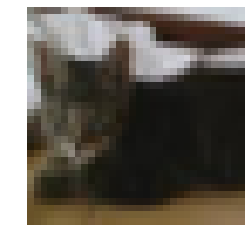

Cat:


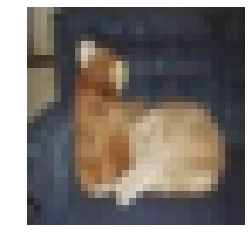

Cat:


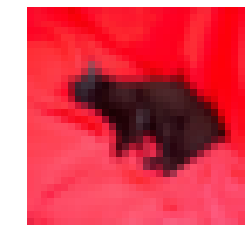

Cat:


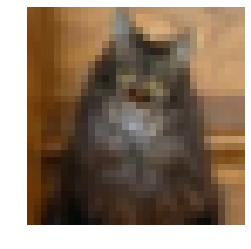

Dog:


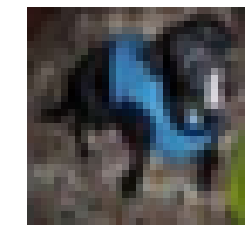

Cat:


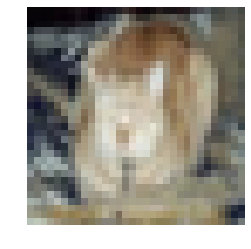

Cat:


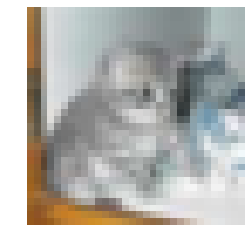

Cat:


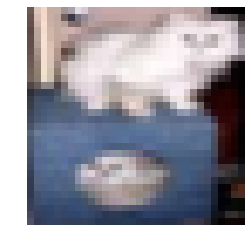

Cat:


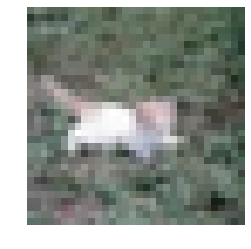

Dog:


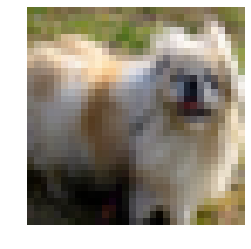

In [2]:
# Loop over the input files and load the data into memory

data = labels = 0

for i in range(1,6):
    f = open("data_batch_{0}".format(i),"rb")
    dic = pickle.load(f,encoding='bytes')
    
    new_labels = np.array(dic[b'labels'])
    new_data = np.array(dic[b'data'])

    if i == 1:
        data = new_data
        labels = new_labels
    else:
        data = np.concatenate((data,new_data))
        labels = np.concatenate((labels,new_labels))

# One example is one row. We need to reformat this into the 
# proper shape (row, color, spatial direction, spatial direction) to use as NN input       
data = data.reshape(-1,3,32,32).swapaxes(2,3)

# This mask is `True` for all events that are cat (labels==3) or dog (labels==3)
cat_dog_mask = (labels==3) | (labels==5)

# Select only the cat and dog images
data = data[cat_dog_mask]
labels = labels[cat_dog_mask]

# transform the label from 3=cat,5=dog to 0=cat,1=dog
labels = (labels-3)/2

# Display the first 10 images
print("Here come 10 cat and dog images")
for i in range(10):
    plt.axis('off')

    image = data[i].swapaxes(0,2)
    label = labels[i]
    
    if label==0:
        print("Cat:")
    else:
        print("Dog:")
    
    plt.imshow(image)
    plt.show()


# Finally split the data into training and testing events
# 9k for training, 1k for testing
X_train = data[:9000]
y_train = labels[:9000]

X_test = data[9000:]
y_test = labels[9000:]


**Define neural network and training hyperparameters. This is the only area you will need to change**

In [10]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(3 * 32 * 32, 10)
        self.fc2 = nn.Linear(10, 2)
                
    def forward(self, x):

        
        x = x.view(-1, 3 * 32 * 32) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Create network object
model = NeuralNet().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# how many epochs to train for
n_epochs = 5

# how many examples / batch
batch_size = 20

# Keep track of the accuracies
train_accs = []
test_accs = []

# Training loop and evaluation below


Epoch: 0 Train Accuracy: 0.5855555555555556 Test Accuracy: 0.534
Epoch: 1 Train Accuracy: 0.5408888888888889 Test Accuracy: 0.529
Epoch: 2 Train Accuracy: 0.5434444444444444 Test Accuracy: 0.525
Epoch: 3 Train Accuracy: 0.5538888888888889 Test Accuracy: 0.519
Epoch: 4 Train Accuracy: 0.5242222222222223 Test Accuracy: 0.516


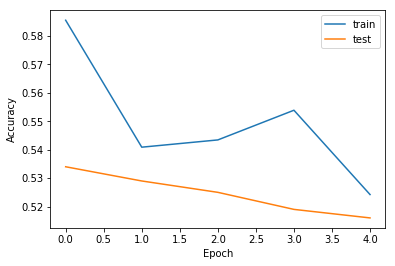

Best test accuracy: 0.534


In [11]:
train_examples = X_train.shape[0]
n_batches = int(train_examples/batch_size)

# Loop over the epochs
for ep in range(n_epochs):

    # reorder the training events for each epoch
    idx = np.arange(X_train.shape[0])
    np.random.shuffle(idx)
    
    X_train = X_train[idx]
    y_train = y_train[idx]
    
    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start:i_stop],dtype=torch.float)
        y = torch.tensor(y_train[i_start:i_stop],dtype=torch.long)

        # Apply the network 
        net_out = model(x)
        
        # Calculate the loss function
        loss = criterion(net_out,y)
                
        # Calculate the gradients
        loss.backward()
        
        # Update the weights
        optimizer.step()
    # end of loop over batches
        
    # Calculate predictions on training and testing data
    y_pred_train = nn.Softmax(dim=1)(model(torch.tensor(X_train,dtype=torch.float))).detach().numpy()
    y_pred = nn.Softmax(dim=1)(model(torch.tensor(X_test,dtype=torch.float))).detach().numpy()

    # Calculate accuracy on training and testing data
    train_acc = sum(y_train == np.argmax(y_pred_train,axis=1)) / y_train.shape[0]
    test_acc = sum(y_test == np.argmax(y_pred,axis=1)) / y_test.shape[0]
    
    # print some information
    print("Epoch:",ep, "Train Accuracy:", train_acc,  "Test Accuracy:", test_acc)
    
    # and store the accuracy for later use
    train_accs.append(train_acc)
    test_accs.append(test_acc)
# end of loop over epochs
    
# Prepare and show accuracy over time
plt.axis('on')
plt.plot(train_accs,label="train")
plt.plot(test_accs,label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

print("Best test accuracy:",max(test_accs))


# Homework

Again we start from a fully working setup (that does not do a very good job yet). Turn this into a network that reaches a maximum testing accuracy of at least 70 %.

* Turn this into a convolutional network by adding [convolution] (`nn.Conv2d`) and [pooling] (`MaxPool2d`) layers as discussed in the lecture. Remember that you need to transform (flatten) when going from color-images to fully connected layers via `x = x.view(-1, number_of_nodes)`. For a 16x16 images with 20 colors ` number_of_nodes` would be `16*16*20=5120`.
* You can also vary hyperparameters such as learning rate, number of epochs and batch size.
* If overtraining becomes an issue, you can experiment with [dropout] (`nn.Dropout`).

[convolution]: https://pytorch.org/docs/stable/nn.html#conv2d
[pooling]: https://pytorch.org/docs/stable/nn.html#maxpool2d
[dropout]: https://pytorch.org/docs/stable/nn.html#dropout
